# Hashtag Subgraphs Metric Comparisons
The idea of the following analysis is to wrap up the results collected throughout the 6.x notebooks and include a few visualizations that better highlight the differences between random subgraphs and hashtag subgraphs, plus a joint comparison between the different hashtag subgraphs that I've individually analyzed.

In [1]:
import snap
from snap import TUNGraph
import os
import sys
import operator
import pandas as pd
import subprocess
import numpy as np
import csv
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
from __future__ import print_function
from IPython.display import HTML, display
import tabulate
import json
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from collections import Counter
import re

# Set Seaborn defaults
sns.set()
%matplotlib inline
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

# Global variables
data_dir = "../data"
pictures_path = os.path.join("../Pictures", "7.SubgraphsComparison")
tweets_path = "../lib/GetOldTweets-python/out/completed"

In [2]:
def load_graph_from_backup(filename):
    FIn = snap.TFIn("../data/"+filename+".bin")
    graph = snap.TUNGraph.Load(FIn)
    return graph

In [48]:
hashtags = ["jesuischarlie", "brexit","makeamericagreatagain","isis","imwithher","trump","blacklivesmatter","alllivesmatter","indyref"]
hashtags_full = ["JeSuisCharlie","Brexit","MAGA","ISIS","ImWithHer","Trump","BLM","ALM","IndyRef"]

In [13]:
# Map hashtag to corresponding subgraphs for easy retrieval
subgraphs = {hashtag:load_graph_from_backup("mmr_subgraph_"+hashtag) for hashtag in hashtags}

In [327]:
# Create basic dataframe to store all relevant data about the subgraphs
def create_subgraphs_df(hashtags):
    return pd.DataFrame(hashtags,columns=["Hashtag"])

def add_column_to_subgraphs_df(subgraphs_df, data_dict, column_name):
    temp = pd.DataFrame(data_dict.items(),columns=["Hashtag",column_name])
    return subgraphs_df.merge(temp,on="Hashtag")
    
subgraphs_df = create_subgraphs_df(hashtags)

In [328]:
# Map hashtags with full hashtag name to be used as plot labels
full_hashtags_dict = {k:v for k,v in zip(hashtags,hashtags_full)}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, full_hashtags_dict, "Hashtag_Full")

In [329]:
# Map hashtags with colors to keep consistency in all the plots
colors = ["darksalmon","gold","seagreen","royalblue","purple","orange","tomato","slategrey","aquamarine"]
hashtag_to_color = {h:k for h,k in zip(hashtags,colors)}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, hashtag_to_color, "Color")

In [330]:
def plot_subgraphs_comparison(subgraphs_df, metric, linestyle, label_dict, filename, text_pos=None, only_text=False, decimals=False, rotation=0, force_sci=False, dropna=False):
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(12,6)
    fig.set_dpi(100)
    temp = subgraphs_df.sort_values(by="Nodes")
    if dropna:
        temp = temp.dropna()
    temp.plot(x="Nodes",y=metric,style=linestyle,ax=ax, markersize=8)
    for xy in zip(temp["Nodes"], temp[metric], temp["Hashtag_Full"]):
        # Manual annotations adjustments
        if text_pos is None or not xy[2] in text_pos.keys():
            pos = (25,10)
        else:
            pos = text_pos[xy[2]]
        if only_text:
            text = '%s' %xy[2]
        elif decimals:
            text = '%s: %.3f' %(xy[2],xy[1])
        else:
            text = '%s: %d' %(xy[2],int(xy[1]))
        ax.annotate(text, xy=(xy[0],xy[1]), xycoords='data',
                    xytext=pos, textcoords='offset points',ha='center', va='bottom',fontsize=12,color='blue',rotation=rotation,
                    bbox=dict(boxstyle='round,pad=0.2', fc='yellow', ec="orange", alpha=0.3),
                    arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color="orange"))
    ax.set_xlabel("Nodes", fontsize=10, fontweight="bold")
    ax.set_ylabel(label_dict["y_label"], fontsize=10, fontweight="bold")
    ax.set_title(label_dict["title"])
    if force_sci:
        ax.ticklabel_format(style="sci", axis='y', scilimits=(0,0), useMathText=True)
    fig.set_tight_layout(False)
    plt.savefig(os.path.join(pictures_path,filename+".png"))
    plt.show()

## 1. Collect subgraphs data

In [331]:
# Nodes and edges
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, {hashtag:subgraph.GetNodes() for hashtag,subgraph in subgraphs.iteritems()}, "Nodes")
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, {hashtag:subgraph.GetEdges() for hashtag,subgraph in subgraphs.iteritems()}, "Edges")

In [332]:
# Average degree
avg_degrees = {hashtag:2.0*subgraph.GetEdges()/subgraph.GetNodes() for hashtag,subgraph in subgraphs.iteritems()}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, avg_degrees, "Average Degree")

In [333]:
# Graph density
def get_graph_density(graph):
    edges = graph.GetEdges()
    nodes = graph.GetNodes()
    return 2.0*edges/(nodes*(nodes-1))
densities = {hashtag:get_graph_density(subgraph) for hashtag,subgraph in subgraphs.iteritems()}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, densities, "Graph Density")

In [334]:
# Clustering coefficient
cf = {"brexit": 0.112,
      "trump": 0.097,
      "imwithher": 0.079,
      "indyref": 0.122,
      "isis": 0.118,
      "jesuischarlie": 0.107,
      "alllivesmatter": 0.086,
      "blacklivesmatter": 0.091,
      "makeamericagreatagain": 0.085}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, cf, "Clustering Coefficient")

In [335]:
# MaxCC
max_cc = {"brexit": 377506,
          "trump": 437370,
          "imwithher": 203778,
          "indyref": 65926,
          "isis": 299616,
          "jesuischarlie": 80374,
          "alllivesmatter": 103734,
          "blacklivesmatter": 346663,
          "makeamericagreatagain": 112590}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, max_cc, "MaxCC")

In [336]:
# Average shortest paths length
aspl = {"brexit": 5.59,
        "trump": None,
        "imwithher": 5.65,
        "indyref": 4.17,
        "isis": None,
        "jesuischarlie": 5.67,
        "alllivesmatter": 4.36,
        "blacklivesmatter": 5.03,
        "makeamericagreatagain": 4.9}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, aspl, "ASPL")

In [337]:
# Diameter
diameter = {"brexit": 17,
          "trump": None,
          "imwithher": 19,
          "indyref": 18,
          "isis": None,
          "jesuischarlie": 19,
          "alllivesmatter": 17,
          "blacklivesmatter": 20,
          "makeamericagreatagain": 27}
subgraphs_df = add_column_to_subgraphs_df(subgraphs_df, diameter, "Diameter")

## 2. Subgraph Sizes

In [208]:
def plot_subgraphs_sizes(subgraphs_df):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(12,5)
    fig.set_dpi(100)

    # Ascending order
    for plot in [(ax1,"Nodes"),(ax2,"Edges")]:
        temp = subgraphs_df.sort_values(by=plot[1])
        sns.barplot(x="Hashtag_Full",y=plot[1],data=temp,palette=temp["Color"], ax=plot[0])

    # Common params
    for ax in ax1,ax2:
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_xlabel("Hashtag", fontsize=10, fontweight="bold")
        ax.ticklabel_format(style="sci", axis='y', scilimits=(0,0), useMathText=True)
    ax1.set_ylabel("Nodes", fontsize=10, fontweight="bold")
    ax2.set_ylabel("Edges", fontsize=10, fontweight="bold")
    ax1.set_title(r"Hashtag Subgraphs Size ($N$)")
    ax2.set_title(r"Hashtag Subgraphs Size ($L$)")
    fig.set_tight_layout(False)
    fig.subplots_adjust(bottom=0.3)
    plt.savefig(os.path.join(pictures_path,"subgraphs_sizes.png"))
    plt.show()

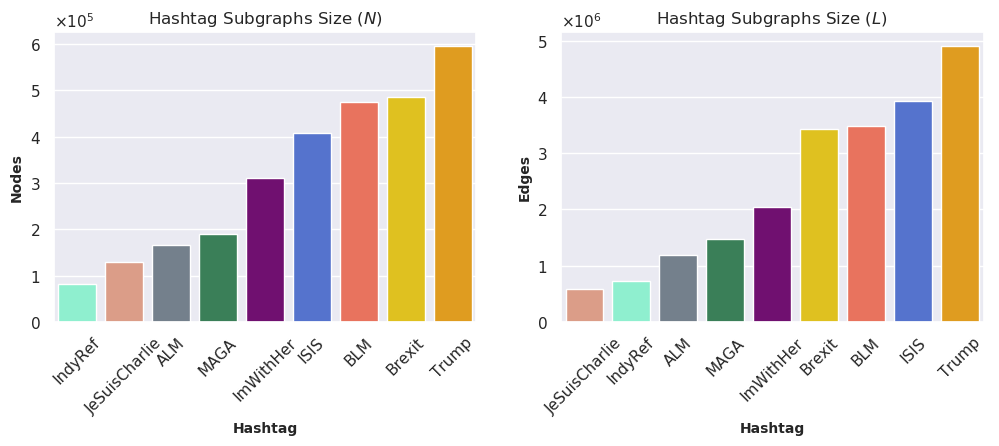

In [209]:
plot_subgraphs_sizes(subgraphs_df)

## 3. Average Degree

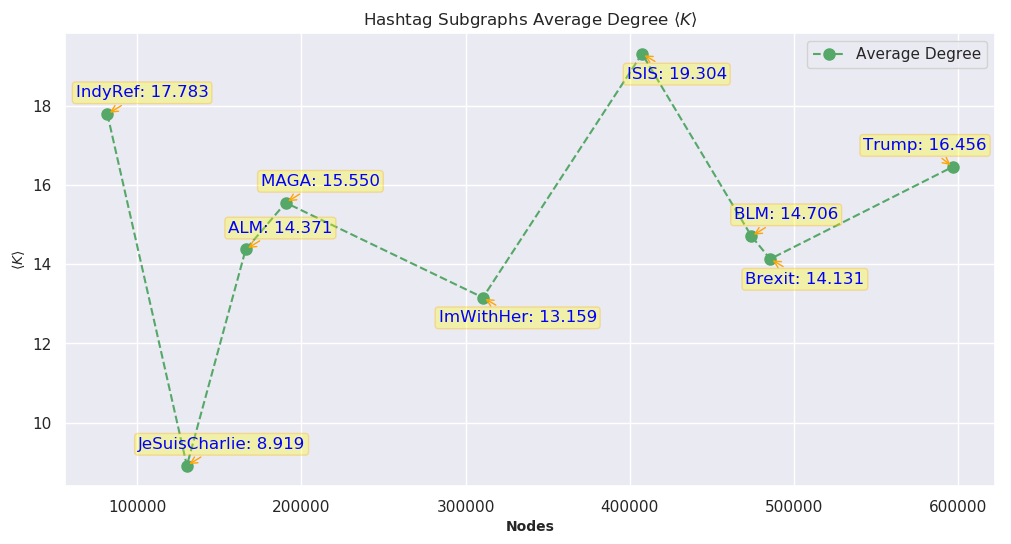

In [321]:
label_dict = {"y_label": r"$\langle K \rangle$",
             "title": r"Hashtag Subgraphs Average Degree $\langle K \rangle$"}
metric = "Average Degree"
linestyle = "go--"
filename = "subgraphs_average_degree"
text_pos = {"ISIS": (25,-20),"Brexit": (25,-20),"ImWithHer": (25,-20), "Trump": (-20,10)}
decimals = True
only_text = False
rotation = 0
force_sci = False
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci)

## 4. Graph Density

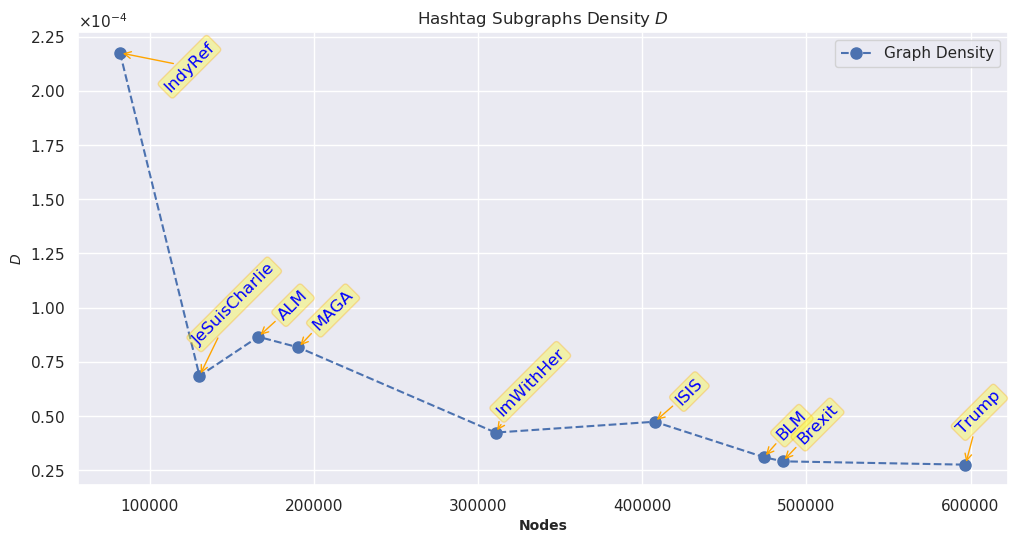

In [322]:
label_dict = {"y_label": r"$D$",
             "title": r"Hashtag Subgraphs Density $D$"}
metric = "Graph Density"
linestyle = "bo--"
filename = "subgraphs_density"
text_pos = {"IndyRef": (50,-30),"JeSuisCharlie": (25,20),"BLM": (20,10), "Trump": (10,20)}
decimals = False
only_text = True
rotation = 45
force_sci = True
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci)

## 5. Clustering Coefficient

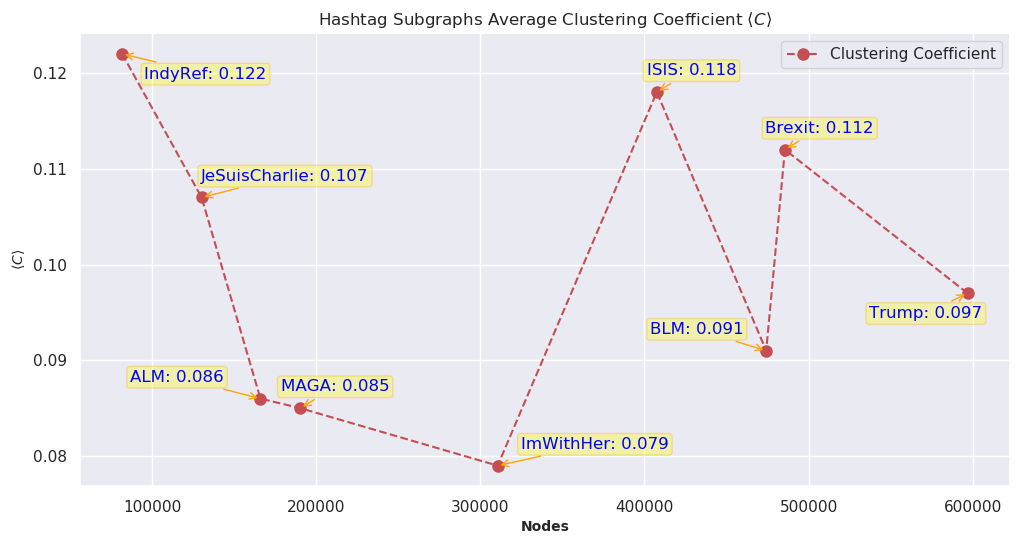

In [323]:
label_dict = {"y_label": r"$\langle C \rangle$",
             "title": r"Hashtag Subgraphs Average Clustering Coefficient $\langle C \rangle$"}
metric = "Clustering Coefficient"
linestyle = "ro--"
filename = "subgraphs_cf"
text_pos = {"IndyRef": (60,-20),"JeSuisCharlie": (60,10),"ImWithHer": (70,10),
            "ALM": (-60,10), "BLM": (-50,10), "Trump": (-30,-20)}
decimals = True
only_text = False
rotation = 0
force_sci = False
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci)

## 6. Max Connected Component

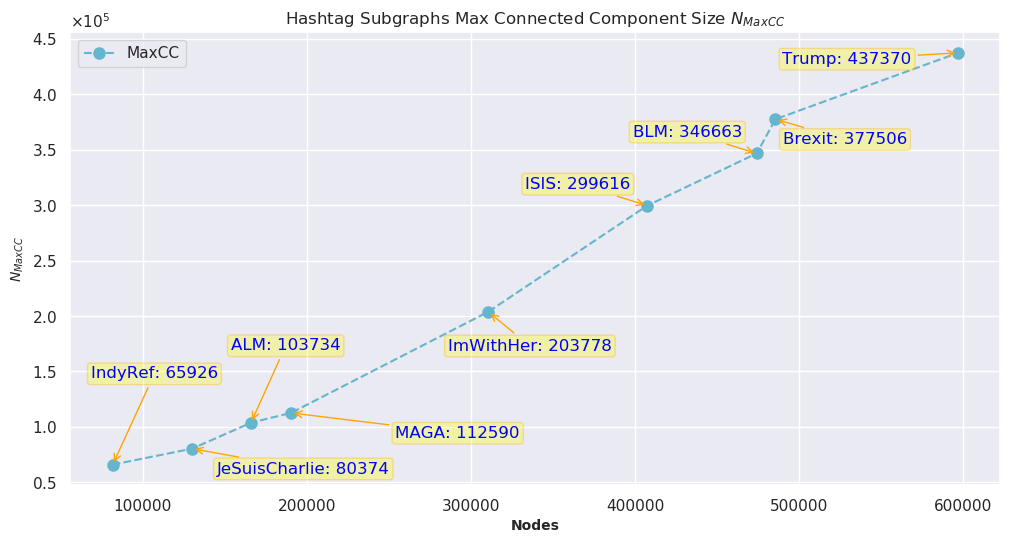

In [324]:
label_dict = {"y_label": r"$N_{MaxCC}$",
             "title": r"Hashtag Subgraphs Max Connected Component Size $N_{MaxCC}$"}
metric = "MaxCC"
linestyle = "co--"
filename = "subgraphs_max_cc"
text_pos = {"IndyRef": (30,60),"JeSuisCharlie": (80,-20),"ImWithHer": (30,-30),
            "ALM": (25,50), "MAGA": (120,-20), "BLM": (-50,10), "Trump": (-80,-10), "ISIS": (-50,10), "Brexit": (50,-20)}
decimals = False
only_text = False
rotation = 0
force_sci = True
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci)

## 7. Average Shortest Paths Length

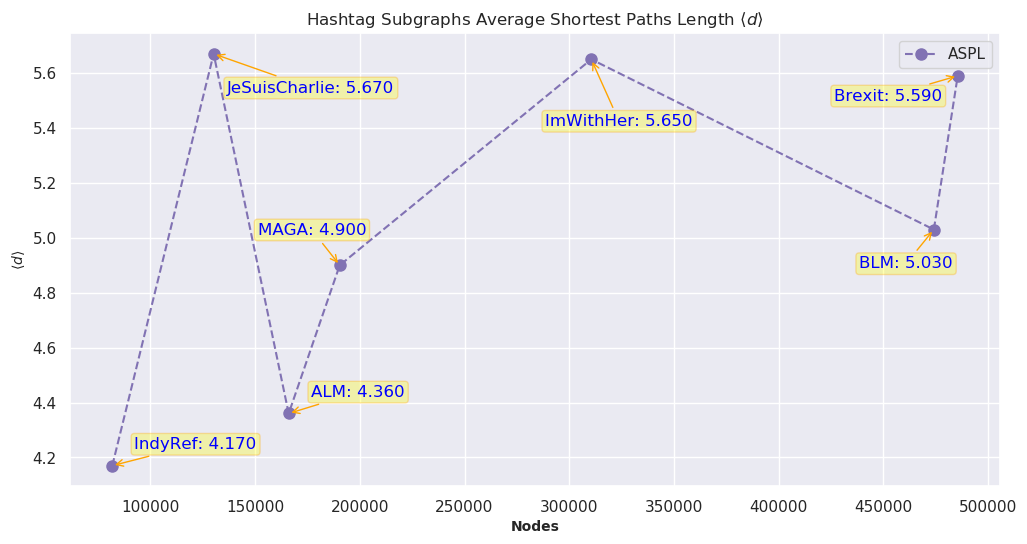

In [351]:
label_dict = {"y_label": r"$\langle d \rangle$",
             "title": r"Hashtag Subgraphs Average Shortest Paths Length $\langle d \rangle$"}
metric = "ASPL"
linestyle = "mo--"
filename = "subgraphs_aspl"
text_pos = {"JeSuisCharlie": (70,-30),"BLM": (-20,-30), "ImWithHer": (20,-50), "MAGA": (-20,20), "IndyRef": (60,10), "ALM": (50,10), "Brexit": (-50,-20)}
decimals = True
only_text = False
rotation = 0
force_sci = False
dropna = True
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci, dropna=dropna)

## 8. Diameter

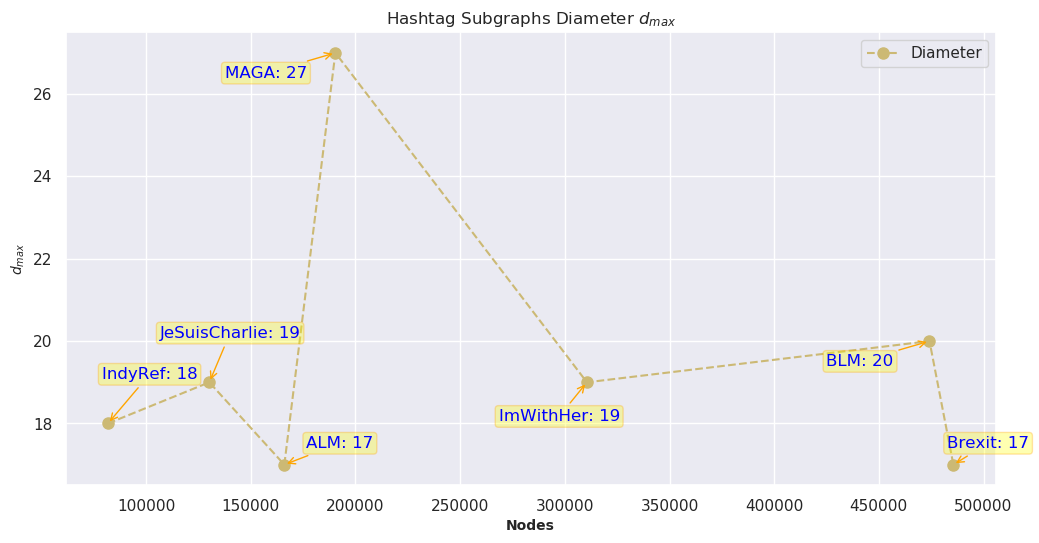

In [354]:
label_dict = {"y_label": r"$d_{max}$",
             "title": r"Hashtag Subgraphs Diameter $d_{max}$"}
metric = "Diameter"
linestyle = "yo--"
filename = "subgraphs_diameter"
text_pos = {"IndyRef": (30,30),"JeSuisCharlie": (15,30),"ALM": (40,10), "MAGA": (-50,-20), "BLM": (-50,-20), "ImWithHer": (-20,-30)}
decimals = False
only_text = False
rotation = 0
force_sci = False
dropna = True
plot_subgraphs_comparison(subgraphs_df,metric,linestyle,label_dict,filename,text_pos=text_pos,only_text=only_text,decimals=decimals, rotation=rotation, force_sci=force_sci, dropna=dropna)

## A. Important considerations for report
- A few hashtags have been used not only with their complete form but also with abbreviations. This is the case for **#MakeAmericaGreatAgain** (widely used with the short version **#MAGA**), as well as **#BLM** or **#ALM** respectively for **#BlackLivesMatter** and **#AllLivesMatter**. By merging the two hashtags I would have probably come up with way larger networks but this would have required additional download time and I preferred to proceed with the analysis;
- Some additional cleaning could have been performed if I had considered to filter out also russian trolls / bots that have been identified by Twitter (ref. [here](https://about.twitter.com/en_us/values/elections-integrity.html#data) and [here](https://github.com/fivethirtyeight/russian-troll-tweets))